In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 8s 777ms/step - loss: 0.3544
Average validation loss: 0.6023253202438354
4/4 [==============================] - 8s 802ms/step - loss: 0.3544 - val_loss: 0.6023
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 773ms/step - loss: 0.2725 - val_loss: 0.6023
Average validation loss: 0.3823205232620239
4/4 [==============================] - 11s 795ms/step - loss: 0.2725 - val_loss: 0.4923
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 15s 774ms/step - loss: 0.2158 - val_loss: 0.4923
Average validation loss: 0.1956777721643448
4/4 [==============================] - 15s 799ms/step - loss: 0.2158 - val_loss: 0.3934
Saved model weights to 'c:\Users\user\Des

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 703ms/step - loss: 0.0226
Average validation loss: 4.05701200634212e-06
8/8 [==============================] - 6s 720ms/step - loss: 0.0226 - val_loss: 4.0570e-06
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 715ms/step - loss: 0.0229 - val_loss: 4.0570e-06
Average validation loss: 0.0
8/8 [==============================] - 12s 729ms/step - loss: 0.0229 - val_loss: 2.0285e-06
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 707ms/step - loss: 0.0225 - val_loss: 2.0285e-06
Average validation loss: 0.0
8/8 [==============================] - 17s 722ms/step - loss: 0.0225 - val_loss: 1.3523e-06
Epoch 4/10
8/8 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 708ms/step - loss: 0.0305
Average validation loss: 0.04003838956062585
12/12 [==============================] - 9s 723ms/step - loss: 0.0305 - val_loss: 0.0400
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 713ms/step - loss: 0.0300 - val_loss: 0.0400
Average validation loss: 0.06892774796271202
12/12 [==============================] - 17s 730ms/step - loss: 0.0300 - val_loss: 0.0545
Epoch 3/10
12/12 [==============================] - 26s 712ms/step - loss: 0.0298 - val_loss: 0.0545
Average validation loss: 0.2051940659681956
12/12 [==============================] - 26s 726ms/step - loss: 0.0298 - val_loss: 0.1047
Epoch 4/10
12/12 [==============================] - 35s 728ms/step - loss: 0.0292 - val_loss: 0.1047
Average validation loss: 0.09422553733457424
12/12 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 714ms/step - loss: 0.0261
Average validation loss: 0.04996331627626205
16/16 [==============================] - 12s 730ms/step - loss: 0.0261 - val_loss: 0.0500
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 727ms/step - loss: 0.0255 - val_loss: 0.0500
Average validation loss: 0.10355830507523933
16/16 [==============================] - 24s 740ms/step - loss: 0.0255 - val_loss: 0.0768
Epoch 3/10
16/16 [==============================] - 35s 721ms/step - loss: 0.0249 - val_loss: 0.0768
Average validation loss: 0.03296639944892377
16/16 [==============================] - 35s 734ms/step - loss: 0.0249 - val_loss: 0.0622
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_20.pth'.
Epoch 4/10
16/16 [====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 713ms/step - loss: 0.0152
Average validation loss: 0.028613517084158956
20/20 [==============================] - 14s 725ms/step - loss: 0.0152 - val_loss: 0.0286
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 728ms/step - loss: 0.0143 - val_loss: 0.0286
Average validation loss: 0.20261648927880743
20/20 [==============================] - 29s 741ms/step - loss: 0.0143 - val_loss: 0.1156
Epoch 3/10
20/20 [==============================] - 44s 716ms/step - loss: 0.0143 - val_loss: 0.1156
Average validation loss: 0.1387032038452162
20/20 [==============================] - 44s 727ms/step - loss: 0.0143 - val_loss: 0.1233
Epoch 4/10
20/20 [==============================] - 58s 714ms/step - loss: 0.0143 - val_loss: 0.1233
Average validation loss: 0.08695701732494854
20/20 [===================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 734ms/step - loss: 0.0150
Average validation loss: 0.02254664432257414
24/24 [==============================] - 18s 748ms/step - loss: 0.0150 - val_loss: 0.0225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 705ms/step - loss: 0.0137 - val_loss: 0.0225
Average validation loss: 0.01879995750884215
24/24 [==============================] - 35s 718ms/step - loss: 0.0137 - val_loss: 0.0207
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 709ms/step - loss: 0.0134 - val_loss: 0.0207
Average validation loss: 0.020673915122946102
24/24 [==============================] - 53s 722ms/step - loss: 0.0134 - val_loss: 0.0207
Epoch 4/10
24/24 [===

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 710ms/step - loss: 0.0187
Average validation loss: 0.3733417347073555
40/40 [==============================] - 29s 723ms/step - loss: 0.0187 - val_loss: 0.3733
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 734ms/step - loss: 0.0177 - val_loss: 0.3733
Average validation loss: 0.04570946469902992
40/40 [==============================] - 59s 747ms/step - loss: 0.0177 - val_loss: 0.2095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 721ms/step - loss: 0.0172 - val_loss: 0.2095
Average validation loss: 0.10517892502248287
40/40 [==============================] - 88s 734ms/step - loss: 0.0172 - val_loss: 0.1747
Epoch 4/10
40/40 [=====

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 725ms/step - loss: 0.0135
Average validation loss: 0.0121465789919597
48/48 [==============================] - 36s 738ms/step - loss: 0.0135 - val_loss: 0.0121
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 714ms/step - loss: 0.0122 - val_loss: 0.0121
Average validation loss: 0.014276336149123381
48/48 [==============================] - 70s 726ms/step - loss: 0.0122 - val_loss: 0.0132
Epoch 3/10
48/48 [==============================] - 105s 719ms/step - loss: 0.0117 - val_loss: 0.0132
Average validation loss: 0.01828539761330224
48/48 [==============================] - 106s 731ms/step - loss: 0.0117 - val_loss: 0.0149
Epoch 4/10
48/48 [==============================] - 140s 713ms/step - loss: 0.0110 - val_loss: 0.0149
Average validation loss: 0.015190264854785104
48/48 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 722ms/step - loss: 0.0157
Average validation loss: 0.02522324997944127
56/56 [==============================] - 41s 735ms/step - loss: 0.0157 - val_loss: 0.0252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 720ms/step - loss: 0.0142 - val_loss: 0.0252
Average validation loss: 0.030557762817937015
56/56 [==============================] - 82s 733ms/step - loss: 0.0142 - val_loss: 0.0279
Epoch 3/10
56/56 [==============================] - 123s 718ms/step - loss: 0.0129 - val_loss: 0.0279
Average validation loss: 0.03054387846546826
56/56 [==============================] - 123s 731ms/step - loss: 0.0129 - val_loss: 0.0288
Epoch 4/10
56/56 [==============================] - 163s 717ms/step - loss: 0.0124 - val_loss: 0.0288
Average validation loss: 0.04834488209045804
56/56 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 732ms/step - loss: 0.0110
Average validation loss: 0.010537636301883412
64/64 [==============================] - 48s 744ms/step - loss: 0.0110 - val_loss: 0.0105
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 718ms/step - loss: 0.0099 - val_loss: 0.0105
Average validation loss: 0.011322232961418866
64/64 [==============================] - 94s 730ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 3/10
64/64 [==============================] - 141s 724ms/step - loss: 0.0089 - val_loss: 0.0109
Average validation loss: 0.013349413814609079
64/64 [==============================] - 142s 737ms/step - loss: 0.0089 - val_loss: 0.0117
Epoch 4/10
64/64 [==============================] - 188s 724ms/step - loss: 0.0081 - val_loss: 0.0117
Average validation loss: 0.01595483667956188
64/64 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 714ms/step - loss: 0.0115
Average validation loss: 0.01109615474059764
72/72 [==============================] - 52s 726ms/step - loss: 0.0115 - val_loss: 0.0111
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 722ms/step - loss: 0.0093 - val_loss: 0.0111
Average validation loss: 0.010588848769354323
72/72 [==============================] - 105s 735ms/step - loss: 0.0093 - val_loss: 0.0108
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 159s 741ms/step - loss: 0.0081 - val_loss: 0.0108
Average validation loss: 0.01615736038527555
72/72 [==============================] - 160s 754ms/step - loss: 0.0081 - val_loss: 0.0126
Epoch 4/10
72/72 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 61s 766ms/step - loss: 0.0102
Average validation loss: 0.01014410489005968
80/80 [==============================] - 62s 779ms/step - loss: 0.0102 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 125s 787ms/step - loss: 0.0090 - val_loss: 0.0101
Average validation loss: 0.018238046765327455
80/80 [==============================] - 126s 800ms/step - loss: 0.0090 - val_loss: 0.0142
Epoch 3/10
80/80 [==============================] - 189s 787ms/step - loss: 0.0079 - val_loss: 0.0142
Average validation loss: 0.00919054434634745
80/80 [==============================] - 190s 799ms/step - loss: 0.0079 - val_loss: 0.0125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_100.pth'.
Epoch 4/10
80/8

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 70s 728ms/step - loss: 0.0131
Average validation loss: 0.027983695583619312
96/96 [==============================] - 71s 740ms/step - loss: 0.0131 - val_loss: 0.0280
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 141s 723ms/step - loss: 0.0107 - val_loss: 0.0280
Average validation loss: 0.0209856573034853
96/96 [==============================] - 142s 735ms/step - loss: 0.0107 - val_loss: 0.0245
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 212s 728ms/step - loss: 0.0096 - val_loss: 0.0245
Average validation loss: 0.023868638995433383
96/96 [==============================] - 213s 740ms/step - loss: 0.0096 - val_loss: 0.0243
Epoch 4/10
96/9

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 721ms/step - loss: 0.0121
Average validation loss: 0.017459335481981125
120/120 [==============================] - 88s 734ms/step - loss: 0.0121 - val_loss: 0.0175
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 727ms/step - loss: 0.0104 - val_loss: 0.0175
Average validation loss: 0.06523643304378007
120/120 [==============================] - 177s 739ms/step - loss: 0.0104 - val_loss: 0.0413
Epoch 3/10
120/120 [==============================] - 263s 720ms/step - loss: 0.0100 - val_loss: 0.0413
Average validation loss: 0.03384631655408157
120/120 [==============================] - 265s 733ms/step - loss: 0.0100 - val_loss: 0.0388
Epoch 4/10
120/120 [==============================] - 351s 724ms/step - loss: 0.0093 - val_loss: 0.0388
Average validation loss: 0.011411923639129403
120/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 721ms/step - loss: 0.0108
Average validation loss: 0.18233641252356453
144/144 [==============================] - 106s 733ms/step - loss: 0.0108 - val_loss: 0.1823
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 722ms/step - loss: 0.0094 - val_loss: 0.1823
Average validation loss: 0.10552629373139805
144/144 [==============================] - 212s 735ms/step - loss: 0.0094 - val_loss: 0.1439
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 0.0087 - val_loss: 0.1439
Average validation loss: 0.10191929736452544
144/144 [==============================] - 317s 732ms/step - loss: 0.0087 - val_loss: 0.1299
Sa

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 0.0065
Average validation loss: 0.011275087219109992
160/160 [==============================] - 117s 734ms/step - loss: 0.0065 - val_loss: 0.0113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 233s 722ms/step - loss: 0.0058 - val_loss: 0.0113
Average validation loss: 0.018642247644823775
160/160 [==============================] - 235s 734ms/step - loss: 0.0058 - val_loss: 0.0150
Epoch 3/10
160/160 [==============================] - 351s 725ms/step - loss: 0.0055 - val_loss: 0.0150
Average validation loss: 0.01831206476596776
160/160 [==============================] - 353s 738ms/step - loss: 0.0055 - val_loss: 0.0161
Epoch 4/10
160/160 [==============================] - 468s 720ms/step - loss: 0.0052 - val_loss: 0.0161
Average validation loss: 0.03245081544175434
16

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 722ms/step - loss: 0.0108
Average validation loss: 0.01321183685111464
200/200 [==============================] - 147s 735ms/step - loss: 0.0108 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 292s 723ms/step - loss: 0.0094 - val_loss: 0.0132
Average validation loss: 0.009234363315626978
200/200 [==============================] - 294s 735ms/step - loss: 0.0094 - val_loss: 0.0112
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 439s 724ms/step - loss: 0.0089 - val_loss: 0.0112
Average validation loss: 0.00867932330351323
200/200 [==============================] - 441s 737ms/step - loss: 0.0089 - val_loss: 0.0104
S

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:53 - loss: 0.0106

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 722ms/step - loss: 0.0095
Average validation loss: 0.010897337081308934
240/240 [==============================] - 176s 735ms/step - loss: 0.0095 - val_loss: 0.0109
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 350s 723ms/step - loss: 0.0079 - val_loss: 0.0109
Average validation loss: 0.043986602905742224
240/240 [==============================] - 353s 735ms/step - loss: 0.0079 - val_loss: 0.0274
Epoch 3/10
240/240 [==============================] - 526s 723ms/step - loss: 0.0075 - val_loss: 0.0274
Average validation loss: 0.016393188511090766
240/240 [==============================] - 529s 735ms/step - loss: 0.0075 - val_loss: 0.0238
Epoch 4/10
240/240 [==============================] - 702s 721ms/step - loss: 0.0071 - val_loss: 0.0238
Average validation loss: 0.033356880947224235


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.04131814065548582, 0.07479409663605853, 0.15258442156042182, 0.06357446851175638, 0.041177193041342826, 0.03340378485216548, 0.033158572913617, 0.08131844863391641, 0.018435462194307882, 0.016199769669590133, 0.011664289654016072, 0.01076090467985725, 0.017906944611284798, 0.07587152365274646, 0.04870917271385194, 0.013534548521011385, 0.014601730890485361, 0.011212679087624364]
std_val_losses =  [0.10320920454757358, 0.06363449392659169, 0.12607459003097574, 0.0461049057504259, 0.03473027730608583, 0.030456518734049438, 0.052175306906989516, 0.1505292043525996, 0.011903473565789682, 0.017944800872248257, 0.009520261049808175, 0.012314206511084263, 0.014376329927226452, 0.07886581574048725, 0.0809181152268752, 0.01876572160601337, 0.019547563630275593, 0.012962705701873734]


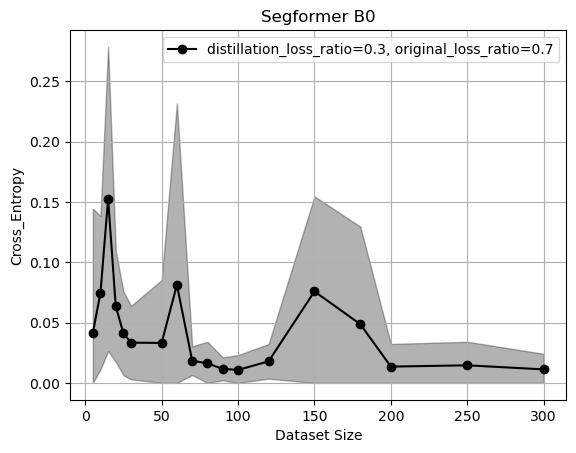

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()